# Image Convolution and Deconvolution based on FFT

This notebook display the convolution and deconvolution process through the FFT.
The deconvolution process uses the Richarson-Lucy algorithm for image deconvolution

In [29]:
import pyclesperanto as cle
import numpy as np
from skimage.io import imread
from matplotlib import pyplot as plt

cle.select_device(1,"gpu")

(OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.230.02
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24217 MB
	Maximum Object Size:         6054 MB
	Max Clock Frequency:         2625 MHz
	Image Support:               Yes

## Load an image, psf, and ground truth

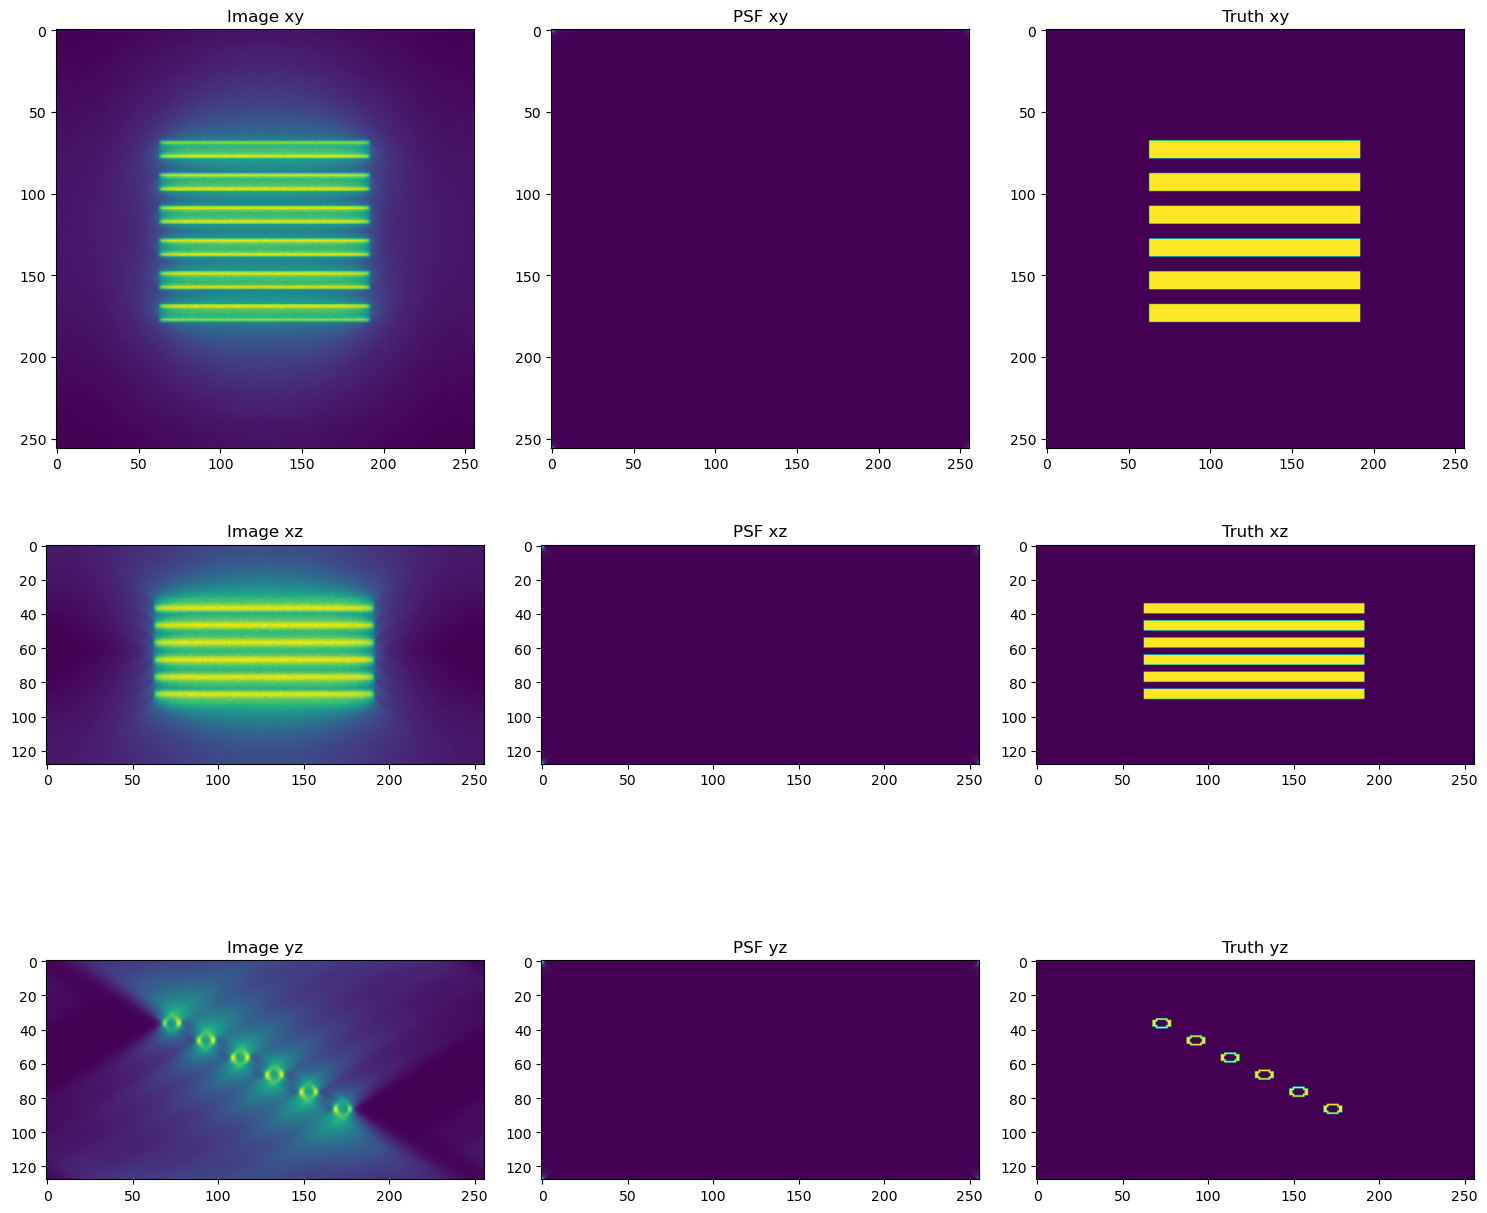

In [30]:
data_folder = '/home/strigaud/Downloads/deconvolution'
im_name = 'Bars-G10-P30-stack.tif'
psf_name = 'PSF-Bars-stack.tif'
truth_name = 'Bars-stack.tif'

im = imread(data_folder + '/' + im_name).astype(np.float32)
psf = imread(data_folder + '/' + psf_name).astype(np.float32)
# shift the psf center to the image top left corner (central pixel at 0,0,0)
psf = np.roll(psf, -np.array(psf.shape) // 2, tuple(range(psf.ndim)))

truth = imread(data_folder + '/' + truth_name).astype(np.float32)

# plot the image, psf and ground truth in a subplot
fig, axs = plt.subplots(3,3, figsize=(15,13))
ax = axs.ravel()

ax[0].imshow(im.max(axis=0))
ax[0].set_title('Image xy')
ax[3].imshow(im.max(axis=1))
ax[3].set_title('Image xz')
ax[6].imshow(im.max(axis=2))
ax[6].set_title('Image yz')

ax[1].imshow(psf.max(axis=0))
ax[1].set_title('PSF xy')
ax[4].imshow(psf.max(axis=1))
ax[4].set_title('PSF xz')
ax[7].imshow(psf.max(axis=2))
ax[7].set_title('PSF yz')

ax[2].imshow(truth.max(axis=0))
ax[5].imshow(truth.max(axis=1))
ax[8].imshow(truth.max(axis=2))
ax[2].set_title('Truth xy')
ax[5].set_title('Truth xz')
ax[8].set_title('Truth yz')

plt.tight_layout()
plt.show()

## Convolution operation

First test to apply a convolution between two arrays. Both `input` and `kernel` must have same dimensions, and the kernel must be cyclically shift so that the central element of the kernel is at `(0,0,)`.

In [35]:
# Create an example input image
input_np = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]], dtype=np.float32)

# Create a kernel (e.g., 3x3 averaging filter)
kernel_np = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=np.float32)

# Convert to GPU arrays
input_gpu = cle.push(input_np)
kernel_gpu = cle.push(kernel_np)

# Create an output array with the same shape as input
output_gpu = cle.create_like(input_gpu)

# Call _convolution (not typically recommended)
output_gpu = cle.__experimental__.vk_convolution(input_gpu, kernel_gpu, output_gpu, correlate=False)

# Retrieve result
output_np = cle.pull(output_gpu)
print(output_np)

[[36. 36. 36.]
 [36. 36. 36.]
 [36. 36. 36.]]


If we test on our real image, convolving the `truth` with the `psf` we should get the `image` output:

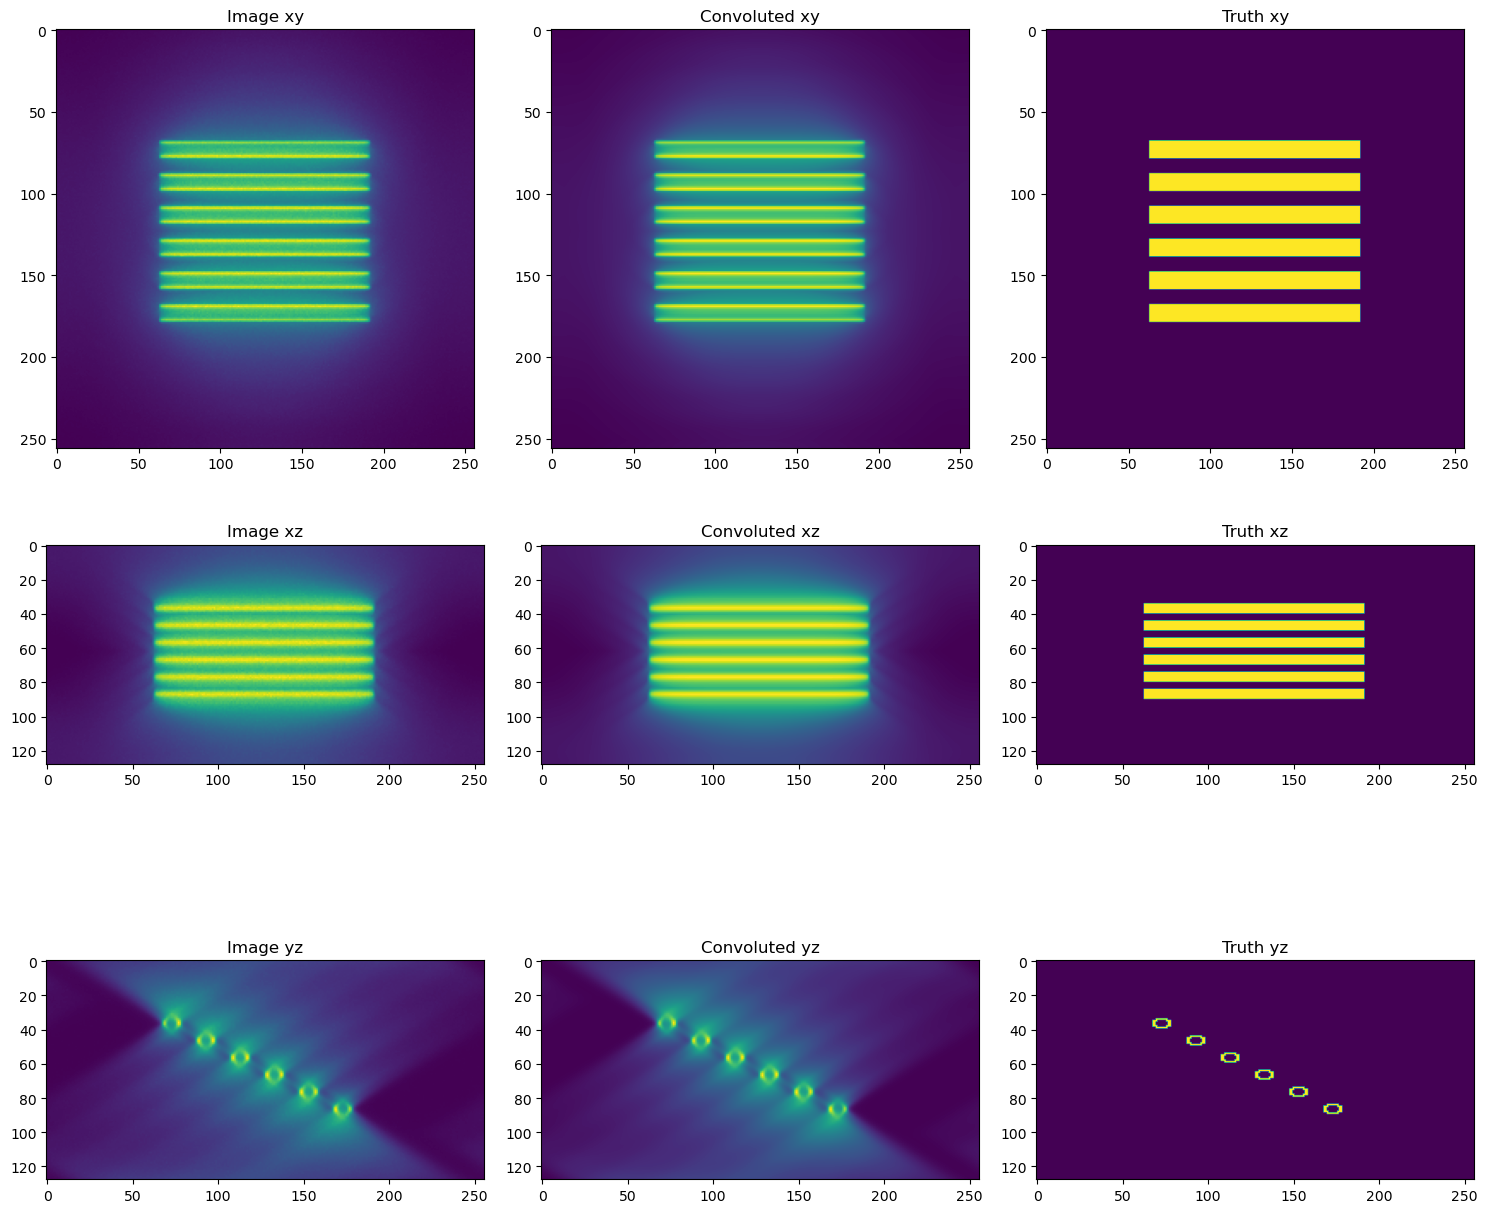

In [36]:
# Convert to GPU arrays
input_gpu = cle.push(truth)
kernel_gpu = cle.push(psf)
output_gpu = cle.create_like(input_gpu)

# Call _convolution (not typically recommended)
cle.__experimental__.vk_convolution(input_gpu, kernel_gpu, output_gpu, correlate=False)

# Retrieve result
output_np = cle.pull(output_gpu)
# plot the image, psf and ground truth in a subplot
fig, axs = plt.subplots(3,3, figsize=(15,13))
ax = axs.ravel()

ax[0].imshow(im.max(axis=0))
ax[0].set_title('Image xy')
ax[3].imshow(im.max(axis=1))
ax[3].set_title('Image xz')
ax[6].imshow(im.max(axis=2))
ax[6].set_title('Image yz')

ax[1].imshow(output_np.max(axis=0))
ax[1].set_title('Convoluted xy')
ax[4].imshow(output_np.max(axis=1))
ax[4].set_title('Convoluted xz')
ax[7].imshow(output_np.max(axis=2))
ax[7].set_title('Convoluted yz')

ax[2].imshow(truth.max(axis=0))
ax[5].imshow(truth.max(axis=1))
ax[8].imshow(truth.max(axis=2))
ax[2].set_title('Truth xy')
ax[5].set_title('Truth xz')
ax[8].set_title('Truth yz')

plt.tight_layout()
plt.show()

## Deconvolution process

For the deconvolution we do the inverse of the convolution, from the `image` and the `psf`, try to get back the `truth`.

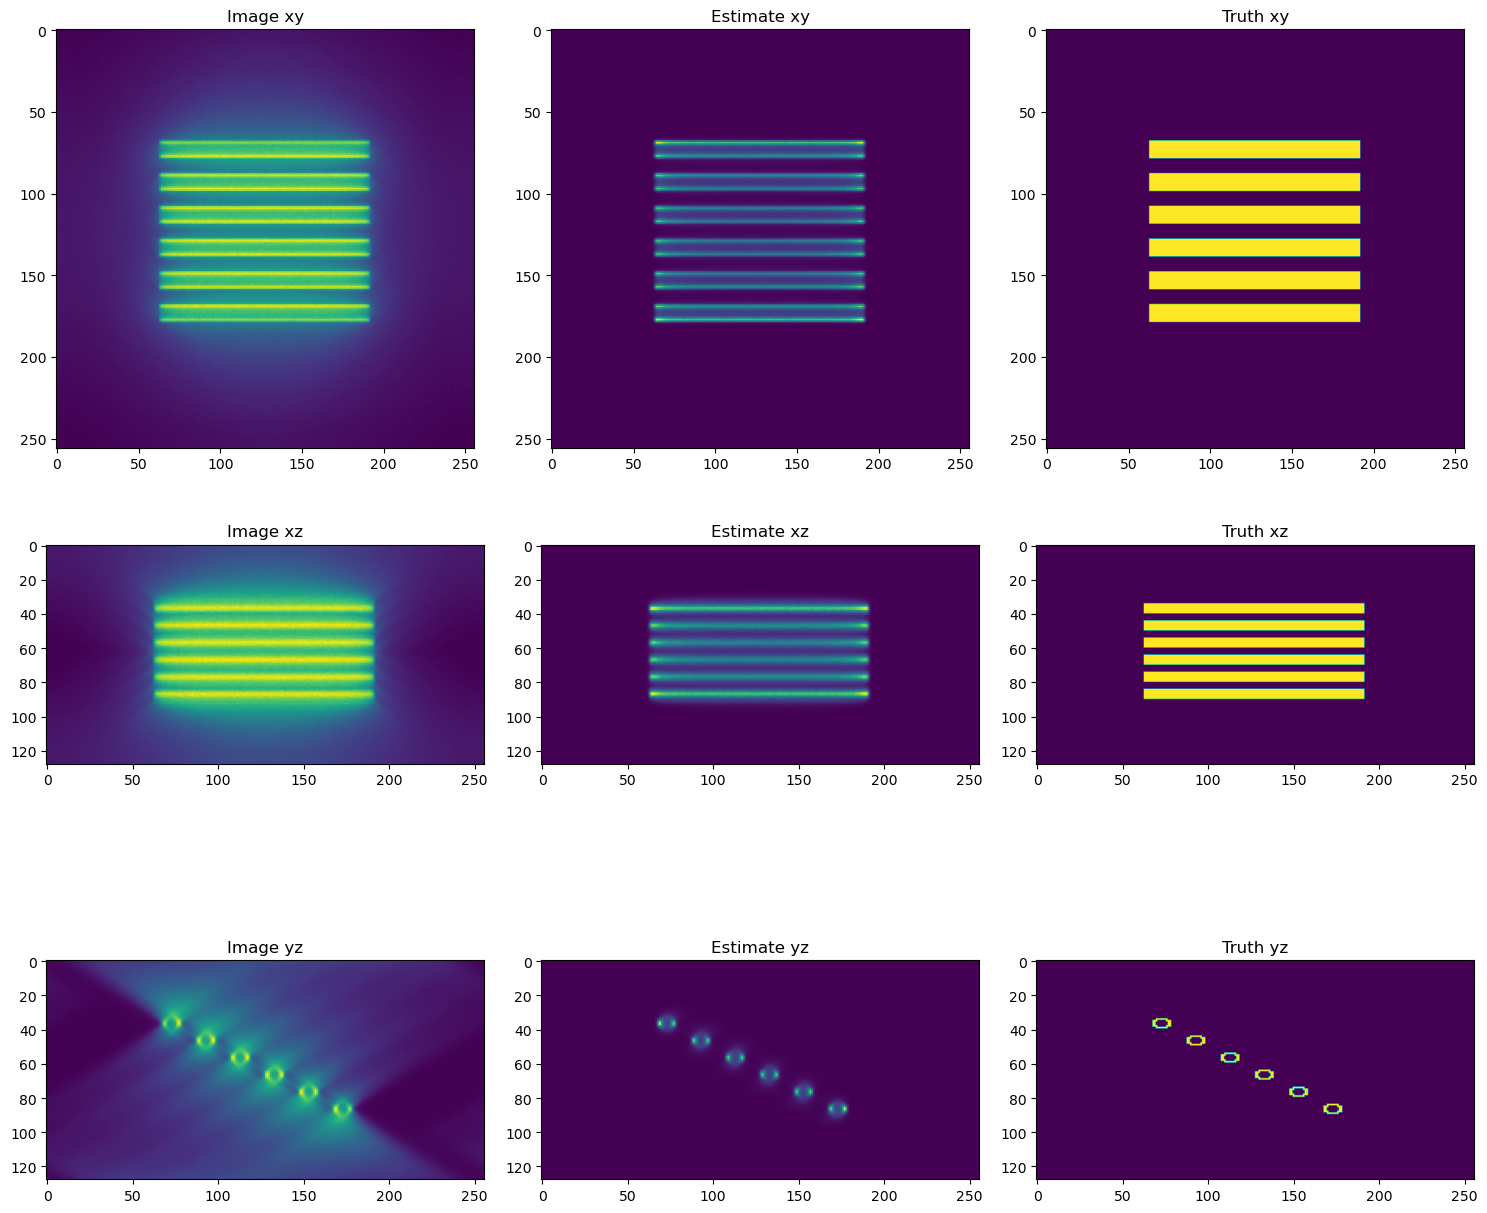

In [37]:
# deconvolution
input_gpu = cle.push(im)
kernel_gpu = cle.push(psf)
output_gpu = cle.create_like(input_gpu)
input_gpu.copy(output_gpu)


cle.__experimental__.vk_deconvolution(input_gpu, kernel_gpu, None, output_gpu, 100, 0)
out = cle.pull(output_gpu)


fig, axs = plt.subplots(3,3, figsize=(15,13))
ax = axs.ravel()

ax[0].imshow(im.max(axis=0))
ax[0].set_title('Image xy')
ax[3].imshow(im.max(axis=1))
ax[3].set_title('Image xz')
ax[6].imshow(im.max(axis=2))
ax[6].set_title('Image yz')

ax[1].imshow(out.max(axis=0))
ax[1].set_title('Estimate xy')
ax[4].imshow(out.max(axis=1))
ax[4].set_title('Estimate xz')
ax[7].imshow(out.max(axis=2))
ax[7].set_title('Estimate yz')

ax[2].imshow(truth.max(axis=0))
ax[5].imshow(truth.max(axis=1))
ax[8].imshow(truth.max(axis=2))
ax[2].set_title('Truth xy')
ax[5].set_title('Truth xz')
ax[8].set_title('Truth yz')

plt.tight_layout()
plt.show()